# Machine Learning Using Random Forest Regressor

### Importing Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import mean_squared_log_error
import optuna
import numpy as np

C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Importing Data

In [2]:
df=pd.read_csv('train_aguascalientes.csv')

In [10]:
df.columns

Index(['Semana', 'Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID',
       'Producto_ID', 'Venta_uni_hoy', 'Venta_hoy', 'Dev_uni_proxima',
       'Dev_proxima', 'Demanda_uni_equil', 'Unit_Diff1_Demanda_uni_equil',
       'Unit_Diff2_Demanda_uni_equil', 'Unit_Diff3_Demanda_uni_equil',
       'Unit_Diff4_Demanda_uni_equil', 'CategoriaProducto', 'CategoriaID',
       'WeightGrams', 'PieceAmount'],
      dtype='object')

### Function to get data from csv of Aguacalientes state

In [12]:
def getTrainData(path = 'train_aguascalientes.csv', week = 8):
    df = pd.DataFrame()
    
    for chunk in pd.read_csv(path, chunksize=100000):
        df = pd.concat([df, chunk])
        
    X_train = df.drop(['Demanda_uni_equil','CategoriaProducto','Venta_uni_hoy', 'Venta_hoy', 'Dev_uni_proxima','Dev_proxima'], axis=1).query(f'Semana < {week}')
    y_train = df[['Demanda_uni_equil', 'Semana']].query(f'Semana < {week}').drop('Semana', axis = 1)
    X_validate = df.drop(['Demanda_uni_equil','CategoriaProducto','Venta_uni_hoy', 'Venta_hoy', 'Dev_uni_proxima','Dev_proxima'], axis=1).query(f'Semana == {week}')
    y_validate = df[['Demanda_uni_equil', 'Semana']].query(f'Semana == {week}').drop('Semana', axis = 1)
            
    return X_train , y_train, X_validate, y_validate

In [13]:
#Split the data
X_train, y_train, X_validate, y_validate = getTrainData()


In [14]:
X_validate.columns

Index(['Semana', 'Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID',
       'Producto_ID', 'Unit_Diff1_Demanda_uni_equil',
       'Unit_Diff2_Demanda_uni_equil', 'Unit_Diff3_Demanda_uni_equil',
       'Unit_Diff4_Demanda_uni_equil', 'CategoriaID', 'WeightGrams',
       'PieceAmount'],
      dtype='object')

In [11]:
X_train

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Unit_Diff1_Demanda_uni_equil,Unit_Diff2_Demanda_uni_equil,Unit_Diff3_Demanda_uni_equil,Unit_Diff4_Demanda_uni_equil,CategoriaID,WeightGrams,PieceAmount
0,3,1347,1,900,4711525,1064,0.0,0.0,0.0,0.0,59,255,1
1,3,1347,1,900,4711525,1146,0.0,0.0,0.0,0.0,69,675,1
2,3,1347,1,900,4711525,1150,0.0,0.0,0.0,0.0,18,340,8
3,3,1347,1,900,4711525,1160,0.0,0.0,0.0,0.0,71,450,8
4,3,1347,1,900,4711525,1169,0.0,0.0,0.0,0.0,75,480,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
917714,7,1974,5,3006,653378,45296,497.0,277.0,514.0,388.0,973,335,1
917715,7,1974,5,3006,653378,45447,462.0,-43.0,502.0,219.0,978,50,25
917716,7,1974,5,3006,653378,45449,327.0,23.0,328.0,56.0,980,50,25
917717,7,1974,5,3006,653378,48029,0.0,0.0,0.0,0.0,597,71,1


## Feature Engineering

### Function to set objective parameters for Random Forest Regressor

In [17]:
def objective(trial):
    k = trial.suggest_int("k", 1, X_train.shape[1])
    params = {
        'bootstrap': True,
        'max_depth': trial.suggest_int('max_depth',80, 110),
        'max_features': trial.suggest_int('max_features',2, 3),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf',3, 5),
        'min_samples_split': trial.suggest_int('min_samples_split',8, 12),
        'n_estimators': trial.suggest_int('n_estimators',100,1000),
        'random_state': trial.suggest_int('random_state', 0, 100)
    }
    selected_features = SelectKBest(f_classif, k=k).fit_transform(X_train, y_train['Demanda_uni_equil'])
    model = RandomForestRegressor(**params)
    model.fit(selected_features, y_train['Demanda_uni_equil'])
    selected_features_test = SelectKBest(f_classif, k=k).fit_transform(X_validate, y_validate['Demanda_uni_equil'])
    predictions = model.predict(selected_features_test)
    print(predictions)
    rmsle_val = np.sqrt(mean_squared_log_error(y_validate, predictions))
    return rmsle_val

### Study of the optimal parameters using Optuna

In [18]:
study = optuna.create_study(direction='minimize')# We create a study to get the best parameters
study.optimize(objective, n_trials=30)

[I 2023-12-05 16:27:27,411] A new study created in memory with name: no-name-792e2980-48c7-48af-8b66-b33ba7de0b9f
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-05 16:36:58,811] Trial 0 finished with value: 0.6086309830226799 and parameters: {'k': 5, 'max_depth': 98, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 920, 'random_state': 37}. Best is trial 0 with value: 0.6086309830226799.


[ 12.03195892 171.31302444   8.57702653 ... 420.7101932  295.32484732
 305.52571627]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-05 16:48:29,495] Trial 1 finished with value: 0.6092819251766346 and parameters: {'k': 5, 'max_depth': 81, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 945, 'random_state': 35}. Best is trial 0 with value: 0.6086309830226799.


[ 12.11097246 173.28189665   8.28611133 ... 422.44113698 331.540852
 358.81752898]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-05 16:57:11,761] Trial 2 finished with value: 0.4755871870896077 and parameters: {'k': 10, 'max_depth': 99, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 11, 'n_estimators': 520, 'random_state': 77}. Best is trial 2 with value: 0.4755871870896077.


[ 10.75976598 211.01488274   8.54377654 ... 405.59475695 196.93966365
 201.16732829]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-05 17:15:20,120] Trial 3 finished with value: 0.4767972493244853 and parameters: {'k': 7, 'max_depth': 103, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 949, 'random_state': 99}. Best is trial 2 with value: 0.4755871870896077.


[ 12.16056279 216.29925367   8.27614635 ... 415.09005077 261.37470093
 279.28127164]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-05 17:24:42,576] Trial 4 finished with value: 0.4773524117153469 and parameters: {'k': 7, 'max_depth': 106, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 11, 'n_estimators': 503, 'random_state': 69}. Best is trial 2 with value: 0.4755871870896077.


[ 12.41407162 219.46505379   8.11774504 ... 384.88194706 256.88551482
 286.32791199]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[I 2023-12-05 17:27:12,643] Trial 5 finished with value: 0.7201404021655372 and parameters: {'k': 2, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 461, 'random_state': 17}. Best is trial 2 with value: 0.4755871870896077.


[ 17.09381214 226.92207329   7.73664214 ... 264.446947   179.68630056
 316.76527472]


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
[W 2023-12-05 17:37:40,244] Trial 6 failed with parameters: {'k': 9, 'max_depth': 96, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 705, 'random_state': 81} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\cosme\AppData\Local\Temp\ipykernel_18624\452821747.py", line 16, in objective
    pred

KeyboardInterrupt: 

In [8]:
print('Best hyperparameters:', study.best_params)
print('Best RMSLE:', study.best_value)

NameError: name 'study' is not defined

Trial 2 finished with value: 0.4755871870896077 and parameters: {'k': 10, 'max_depth': 99, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 11, 'n_estimators': 520, 'random_state': 77}. Best is trial 2 with value: 0.4755871870896077
RMSLE=0.4755871870896077

In [19]:

params = {'max_depth': 99,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 11,
 'n_estimators':520,
 'random_state': 77}

## Machine Learning using optimal parameters


### Using SelectKbest to obtain best Xtrain data

In [21]:
selector = SelectKBest(f_classif, k = 10).fit(X_train, y_train['Demanda_uni_equil'])
cols_idxs = selector.get_support(indices=True)
X_train.iloc[:, cols_idxs].columns

Index(['Agencia_ID', 'Canal_ID', 'Producto_ID', 'Unit_Diff1_Demanda_uni_equil',
       'Unit_Diff2_Demanda_uni_equil', 'Unit_Diff3_Demanda_uni_equil',
       'Unit_Diff4_Demanda_uni_equil', 'CategoriaID', 'WeightGrams',
       'PieceAmount'],
      dtype='object')

In [23]:

model2 = RandomForestRegressor(**params)
model2.fit(X_train[['Agencia_ID', 'Canal_ID', 'Producto_ID', 'Unit_Diff1_Demanda_uni_equil',
       'Unit_Diff2_Demanda_uni_equil', 'Unit_Diff3_Demanda_uni_equil',
       'Unit_Diff4_Demanda_uni_equil', 'CategoriaID', 'WeightGrams',
       'PieceAmount']], y_train['Demanda_uni_equil'])
selected_features_test = SelectKBest(f_classif, k=10).fit_transform(X_validate, y_validate['Demanda_uni_equil'])
predictions2 = model2.predict(selected_features_test)
rmsle_val2 = np.sqrt(mean_squared_log_error(y_validate, predictions2))


C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\cosme\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [32]:

print('RMSLE:', rmsle_val2)

RMSLE: 0.4755871870896077


### Model Crossvalidation

In [88]:
from sklearn.model_selection import cross_val_score
randomforestcv = cross_val_score(model2, X_train, y_train['Demanda_uni_equil'],cv=5)


In [89]:
randomforestcv

array([0.06842108, 0.56110777, 0.50802973, 0.7220288 , 0.67401333])

## Data Prediction

In [25]:
import matplotlib.pyplot as plt

In [84]:
def predictDemand(model, week, df): 
    X_train, y_train, X_predict, y_test = getTrainData(week=week)
    predictions = model.predict(X_predict.drop(['Semana', 'Ruta_SAK', 'Cliente_ID' ], axis=1))
    pred_rmsle = np.sqrt(mean_squared_log_error(y_test['Demanda_uni_equil'], predictions))
    
    df_compare = pd.DataFrame({'Real': y_test['Demanda_uni_equil'][0:50], 'Predict': predictions[:50]})
    
    plt.plot(df_compare)
    plt.legend(['Real', 'Predict'])
    plt.title(f'Predictions for week {week}')
    return predictions, pred_rmsle

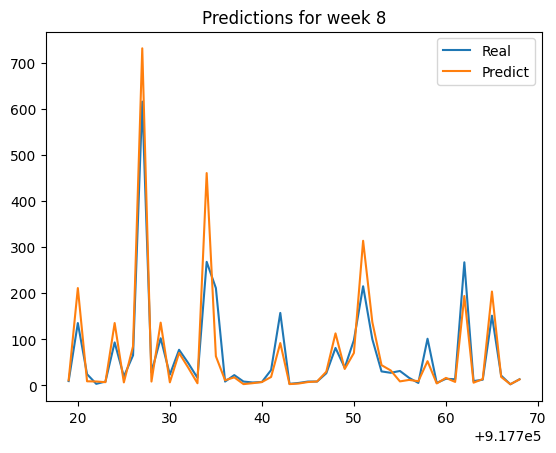

In [85]:
week_8_prediction, week_8_rmsle = predictDemand(model2, 8, df)

### Function to get predicted data

In [26]:
def getPredictData(path = 'train_aguascalientes.csv', week = 8): 
    df = pd.DataFrame()
    
    for chunk in pd.read_csv(path, chunksize=100000):
        df = pd.concat([df, chunk])
        
    df['Demanda_uni_equil'] = np.where(df['Semana'] >= week, 0, df['Demanda_uni_equil'])
    df['Unit_Diff1_Demanda_uni_equil'] = np.where(df['Semana'] == week + 1, 0, df['Unit_Diff1_Demanda_uni_equil'])
            
    return df

### Function to get the Difference between validation data vs predictions

In [86]:
def getDifferencedDemand(df): 
    demand_pivot = df.pivot_table(index=['Semana', 'Cliente_ID', 'Producto_ID', 'Agencia_ID'], values='Demanda_uni_equil', aggfunc='sum')
    demand_pivot[f'Unit_Diff1_Demanda_uni_equil'] = demand_pivot.groupby(['Producto_ID', 'Agencia_ID','Cliente_ID'])['Demanda_uni_equil'].diff(periods=1)
    n_week_df = df.query('Semana == 9').drop('Unit_Diff1_Demanda_uni_equil', axis = 1)
    diff_df = n_week_df.merge(demand_pivot.drop(['Demanda_uni_equil'], axis=1), on=['Semana', 'Cliente_ID', 'Producto_ID', 'Agencia_ID'], how='left')
    diff_df.fillna(0, inplace=True)
    diff_df = pd.concat([df.query('Semana != 9'), diff_df], axis = 0)
    return diff_df

### Get predictions for Week 9

In [96]:
ags_df = getPredictData()

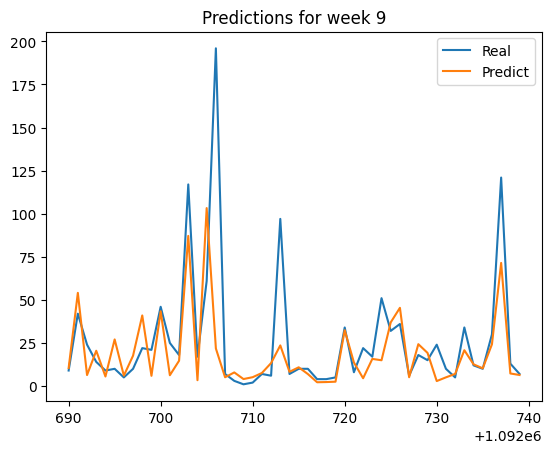

In [98]:
demand_prediction = predictDemand(model2, 9,ags_df)
ags_df.loc[ags_df['Semana'] == 9, 'Demanda_uni_equil'] = demand_prediction[0].astype(int)